In [118]:
import pandas as pd
from random import randint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torcheval.metrics import BinaryAccuracy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import seaborn as sb
import matplotlib.pyplot as plt

Import modul-modul yang diperlukan

In [2]:
from models import InferSent
MODEL_PATH = "encoder/infersent2.pkl"
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [3]:
model.build_vocab_k_words(K=50000)

Vocab size : 50000


Menginstansiasi model infersent untuk menghasilkan sentence embeddings

In [4]:
# Membaca dataset yang telah dibersihkan
dataset = pd.read_json('clean.json')

# List genre yang paling relevan
GENRES = ['Drama', 'Comedy', 'Adventure', 'Action', 'Thriller', 'Romance', 'Mystery', 'Sci-Fi', 'Fantasy']

# Konversi menjadi array of boolean agar dapat diproses pytorch
dataset['Genre'] = dataset['Genre'].apply(lambda x: np.isin(GENRES, x))

Konversi genre pada dataframe menjadi array of boolean

In [5]:
# Menghasilkan sentence embedding
embeddings = model.encode(dataset['Overview'].to_numpy(), bsize=128, tokenize=False, verbose=True)

Nb words kept : 21420/24424 (87.7%)


c:\Users\ardap\OneDrive\Desktop\Koding\Kuliah\Semester 4\Keluarga Berencana\Kelompok\FP-KB\models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


Speed : 57.9 sentences/s (cpu mode, bsize=128)


In [6]:
dataset['Embeddings'] = embeddings.tolist()
dataset = dataset[['Embeddings', 'Genre']]
dataset

,Embeddings,Genre
0,"[0.007468892261385918, 0.31835460662841797, 0....","[True, False, False, False, False, False, Fals..."
1,"[0.007468892261385918, 0.08130999654531479, 0....","[True, False, False, False, False, False, Fals..."
2,"[0.007468892261385918, 0.03828967735171318, 0....","[True, False, False, True, False, False, False..."
3,"[0.007468892261385918, 0.03102203458547592, 0....","[True, False, False, False, False, False, Fals..."
4,"[0.007468892261385918, 0.025840800255537033, 0...","[True, False, False, False, False, False, Fals..."
...,...,...
842,"[0.007468892261385918, 0.18604639172554016, 0....","[False, True, False, False, False, False, Fals..."
843,"[0.007468892261385918, 0.15518277883529663, 0....","[True, True, False, False, False, True, False,..."
844,"[0.007468892261385918, 0.06997597217559814, 0....","[True, False, False, False, False, True, False..."
845,"[0.007468892261385918, 0.023567846044898033, 0...","[True, False, False, False, False, False, Fals..."


Hasil konversi menjadi array of boolean

In [39]:
# Mengasilkan dataset untuk training dan testing (validasi)
train_ds, test_ds = train_test_split(dataset, test_size=0.1)
train_ds = train_ds.reset_index(drop=True)
test_ds = test_ds.reset_index(drop=True)

Memisahkan data untuk training dan testing dengan split 10% (90% training, 10% testing)

In [40]:
# Membuat dataset tensor pytorch
class SynopsisDataset(Dataset):
    def __init__(self, df):
        self.X = torch.Tensor(df['Embeddings'])
        self.y = torch.Tensor(df['Genre'])

    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = SynopsisDataset(train_ds)
test_dataset = SynopsisDataset(test_ds)


Mendefinisikan dataset untuk pytorch agar bisa menggunakan dataloader

In [55]:
# Definisi classification neural network
class ClassificationNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.dense1 = nn.Linear(input_size, 1024)
        self.dense2 = nn.Linear(1024, 1024)
        self.dense3 = nn.Linear(1024, 1024)
        self.dense4 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))
        x = torch.sigmoid(self.dense4(x))
        return x

Mendefinisikan neural network untuk klasifikasi genre

In [10]:
# Hyperparameter model
input_size = 4096
batch_size = 100
num_classes = 9
learning_rate = 1e-3
epochs = 20

In [41]:
# Data loader untuk model
train_load = DataLoader(train_dataset, batch_size, shuffle=True)
test_load = DataLoader(test_dataset, batch_size, shuffle=True)

Menginstansiasikan data loader pytorch

In [146]:
# Instansiasi
cmodel = ClassificationNN(input_size, num_classes)
cmodel

ClassificationNN(
  (dense1): Linear(in_features=4096, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=1024, bias=True)
  (dense3): Linear(in_features=1024, out_features=1024, bias=True)
  (dense4): Linear(in_features=1024, out_features=9, bias=True)
)

Menginstansiasikan neural network klasifikasi

In [147]:
# Rumus loss dan optimizer yang digunakan
loss = nn.BCELoss()
optimizer = optim.Adam(cmodel.parameters(), lr=learning_rate)

Menentukan perhitungan loss dan optimizer yang akan digunakan

In [148]:
# Metrik akurasi training
accuracy = BinaryAccuracy()
history = {'accuracy': [], 'loss': []}
# Training model
for epoch in range(epochs+1):
    for batch_num, (synopses, targets) in enumerate(train_load):
        # Forward. Predict and calculate loss
        scores = cmodel(synopses)
        losses = loss(scores, targets)
        for (output, target) in zip(scores, targets):
            accuracy.update(output, target)
        # Backward propagration
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    acc = accuracy.compute().item()
    print(f'epoch : {epoch}\tloss: {losses.data}\taccuracy : {acc}')
    history['accuracy'].append(acc)
    history['loss'].append(losses.data.item())
    

epoch : 0	loss: 0.41140255331993103	accuracy : 0.7690288424491882
epoch : 1	loss: 0.48275795578956604	accuracy : 0.8057742714881897
epoch : 2	loss: 0.38308796286582947	accuracy : 0.8180227279663086
epoch : 3	loss: 0.4230937063694	accuracy : 0.8241469860076904
epoch : 4	loss: 0.3860051929950714	accuracy : 0.8278214931488037
epoch : 5	loss: 0.3679950535297394	accuracy : 0.8302712440490723
epoch : 6	loss: 0.38357794284820557	accuracy : 0.8320209980010986
epoch : 7	loss: 0.33621516823768616	accuracy : 0.8342629075050354
epoch : 8	loss: 0.30834275484085083	accuracy : 0.8375619649887085
epoch : 9	loss: 0.3289795517921448	accuracy : 0.8403761982917786
epoch : 10	loss: 0.2649426758289337	accuracy : 0.8433945775032043
epoch : 11	loss: 0.2728864550590515	accuracy : 0.8462501168251038
epoch : 12	loss: 0.2709420323371887	accuracy : 0.8489916324615479
epoch : 13	loss: 0.2304953783750534	accuracy : 0.8519455790519714
epoch : 14	loss: 0.18650272488594055	accuracy : 0.8553028106689453
epoch : 15	loss:

Training

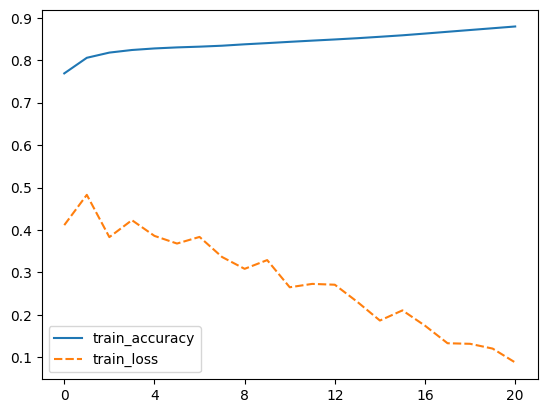

In [151]:
data = {'train_accuracy': history['accuracy'], 'train_loss': history['loss']}
plot = sb.lineplot(data).set_xticks(range(0,len(history['accuracy']),int(len(history['accuracy'])/5)))

Diatas adalah grafik perubahan akurasi dan loss pada saat training

In [156]:

def predict(synopses, tolerance=0.3):
    synopses = model.encode(synopses, bsize=128, tokenize=False, verbose=True)
    result = cmodel(torch.Tensor(synopses))
    genres = []
    for tensor in result:
        for idx ,dim in enumerate(tensor):
            if dim > tolerance: genres.append(GENRES[idx])
            print(dim)
    return genres

predict(['''As a shocking truth about a couple's families emerges, the two lovers discover they are not so different from each other. Tessa is no longer the sweet, simple girl she was when she met Hardin.'''])

Nb words kept : 32/37 (86.5%)
Speed : 3.6 sentences/s (cpu mode, bsize=128)
tensor(0.9131, grad_fn=<UnbindBackward0>)
tensor(0.9369, grad_fn=<UnbindBackward0>)
tensor(4.9106e-05, grad_fn=<UnbindBackward0>)
tensor(1.0867e-08, grad_fn=<UnbindBackward0>)
tensor(4.8591e-05, grad_fn=<UnbindBackward0>)
tensor(0.9373, grad_fn=<UnbindBackward0>)
tensor(0.0034, grad_fn=<UnbindBackward0>)
tensor(0.0040, grad_fn=<UnbindBackward0>)
tensor(0.0978, grad_fn=<UnbindBackward0>)


['Drama', 'Comedy', 'Romance']

Hasil prediksi model klasifikasi